# Preprocess rentangle

Preprocesses the image keeping the aspect ratio of the sides, fitting it into 224x224 and padding the missing space with black colour.

2025-04-10 11:10:23.723 | INFO     | wings.config:<module>:40 - PROJ_ROOT path is: /home/mkrajew/bees
2025-04-10 11:10:23.856 | INFO     | wings.config:<module>:61 - torch.cuda.get_device_name()='NVIDIA RTX A3000 12GB Laptop GPU'


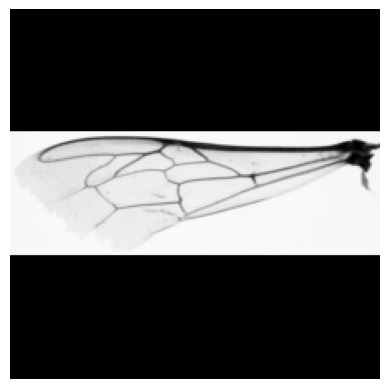

In [1]:
import torch

from wings.dataset import WingsDatasetRectangleImages
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.image_preprocess import fit_rectangle_preprocess, denormalize
from torchvision.io import decode_image
from wings.config import RAW_DATA_DIR, IMG_FOLDER_SUFX

filename = "PL-0001-000420-R.dw.png"

country = filename.split('-', 1)[0]
imgpath = RAW_DATA_DIR / f"{country}{IMG_FOLDER_SUFX}" / filename
image = decode_image(imgpath)
image = image.repeat(3, 1, 1)
image, pad_top, pad_bottom = fit_rectangle_preprocess(image)
image = denormalize(image)

visualize_coords(image, torch.Tensor([0.]))


# Visualization from dataset with target coordinates

In [2]:
import numpy as np
from wings.config import COUNTRIES

test_dataset = WingsDatasetRectangleImages(COUNTRIES, RAW_DATA_DIR, fit_rectangle_preprocess)
max_n = len(test_dataset)

100%|██████████| 21722/21722 [00:00<00:00, 73122.33it/s]


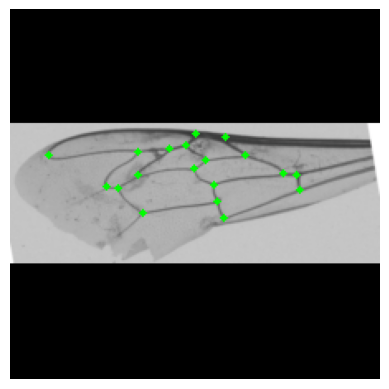

In [22]:
n = np.random.randint(0, max_n)
image, labels = test_dataset[n]
image = denormalize(image)
visualize_coords(image, labels.squeeze(0), spot_size=2)
